In [1]:
import tike.ptycho
import numpy as np
import matplotlib.pyplot as plt
import importlib
import dxchange
import tomopy

In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.6.2.dev12+g24dc522.d20190424
numpy is version 1.16.3


# Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

Normalize input uint8 images to the `[0, 1]` and `[0, pi]` ranges.

In [3]:
maxint = 0.003
pw = 17 # probe width
imgsize = 256
piter = 500
noise = True
model = 'poisson'  # minimization funcitonal (poisson,gaussian)
modelProbe = 'MURA'
name = 'recnoise'+str(noise)+'maxint' + \
    str(maxint)+'prbsize'+str(pw)+'img'+str(imgsize)+str(model)+str(piter)+str(modelProbe)


# amplitude = plt.imread("../tests/data/cameraman.tif") / 255
# phase = plt.imread("../tests/data/peppers.tif") / 255 * np.pi
# phase = tomopy.peppers(128)[0] /  np.amax(tomopy.peppers(128)) * np.pi
amplitude = tomopy.cameraman(256)[0] / np.amax(tomopy.cameraman(128))
phase = plt.imread("../tests/data/Cryptomeria_japonica-0256.tif") / 255 * np.pi

print(np.min(amplitude), np.max(amplitude))
print(np.min(phase), np.max(phase))

0.0 1.0
0.1355196830960303 3.141592653589793


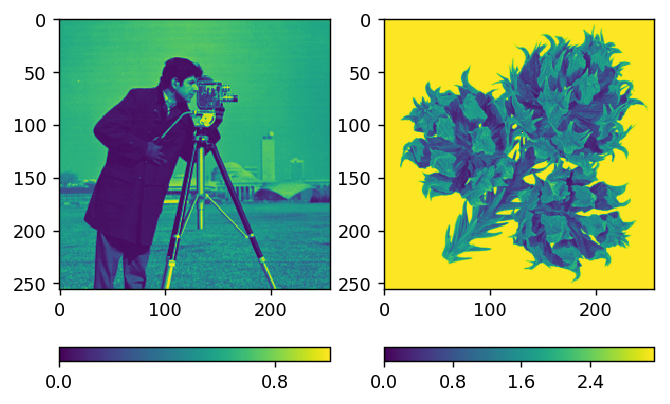

(-1+1.2246467991473532e-16j) (0.893393700388172+0.39776450268675406j)


In [4]:
original = amplitude * np.exp(1j * phase)
tike.plot_phase(original)
original.shape
dxchange.write_tiff(np.abs(original).astype('float32'), 'tmp_MURA/amp/amp_true_'+name) 
dxchange.write_tiff(np.angle(original).astype('float32'), 'tmp_MURA/phase/phase_true_'+name)

### Define the probe

INFO:dxchange.reader:Data successfully imported: /Volumes/SSARIAYDIN/Documents/tike/docs/MURA/MURAs/017.tiff


intensity sum: 0.5020139 0.50201386
amplitude sum: (10.122981+1.8220472j) (10.749821+3.7270641j)


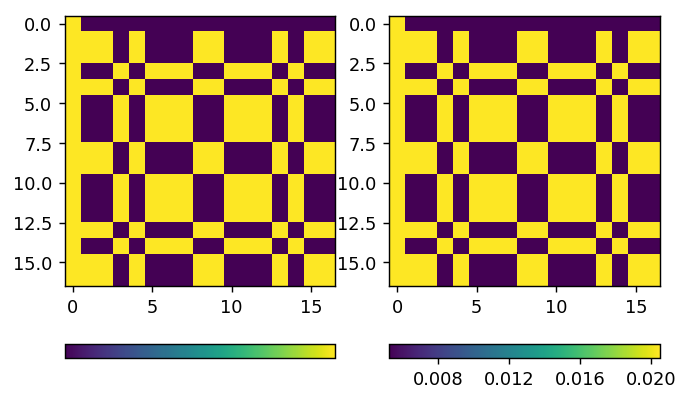

In [5]:
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
prb_gauss = np.sqrt(maxint) * weights * np.exp(1j * weights * 0.2)
prb1 = (dxchange.read_tiff('MURA/MURAs/0'+str(pw)+'.tiff')[0:pw,0:pw]/255.).astype('float32')+1  #load MURA as probe
prb = prb1 * np.exp(1j * 0.2 * prb1)
probe = np.sqrt(np.sum(np.abs(prb_gauss)**2) / np.sum(np.abs(prb)**2)) * prb
print ('intensity sum:', np.sum(np.abs(prb_gauss)**2), np.sum(np.abs(probe)**2))
print ('amplitude sum:', np.sum(prb_gauss), np.sum(probe))
    
tike.plot_complex(probe)

### Define the trajectory

In [7]:
print(np.linspace(0, amplitude.shape[0]-pw, 48, endpoint=False))


[  0.           4.97916667   9.95833333  14.9375      19.91666667
  24.89583333  29.875       34.85416667  39.83333333  44.8125
  49.79166667  54.77083333  59.75        64.72916667  69.70833333
  74.6875      79.66666667  84.64583333  89.625       94.60416667
  99.58333333 104.5625     109.54166667 114.52083333 119.5
 124.47916667 129.45833333 134.4375     139.41666667 144.39583333
 149.375      154.35416667 159.33333333 164.3125     169.29166667
 174.27083333 179.25       184.22916667 189.20833333 194.1875
 199.16666667 204.14583333 209.125      214.10416667 219.08333333
 224.0625     229.04166667 234.02083333]


In [8]:
v, h = np.meshgrid(
    np.linspace(0, amplitude.shape[0]-pw, 48, endpoint=False),
    np.linspace(0, amplitude.shape[0]-pw, 48, endpoint=False),
    indexing='ij'
    )
print(v.shape, h.size)

(48, 48) 2304


## Simulate data acquisition

In [9]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(data_shape=np.ones(2, dtype=int)*pw*4,
                            probe=probe, v=v, h=h,
                            psi=original)
if noise ==True:
    data = np.random.poisson(data).astype('float32')
print("max intensity on the detector: ", np.amax(data)) 
print(data.shape)
data_av = np.mean(data, axis = 0)    #data_sum=np.sum(data, axis = (0,1))      
dxchange.write_tiff(np.fft.fftshift(np.log(np.array(data))), 'dataRecon/dataall'+name)
dxchange.write_tiff(np.fft.fftshift(np.log(np.array(data_av))), 'dataRecon/data'+name)

max intensity on the detector:  89.0
(2304, 67, 67)


/Users/ssariaydin/anaconda3/envs/tike/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


/Users/ssariaydin/anaconda3/envs/tike/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


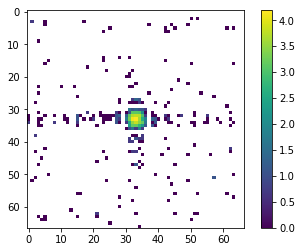

(0.0, 89.0)

In [10]:
plt.imshow(np.fft.fftshift(np.log(data[34])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)


# Reconstruct

Now we need to try and reconstruct psi.

In [11]:
# Start with a guess of all zeros for psi
new_psi = np.ones(original.shape, dtype=complex)

In [ ]:
#for i in range(10):
new_psi, convpsi = tike.ptycho.reconstruct(data=data,
                                  probe=probe, v=v, h=h,
                                  psi=new_psi,
                                  algorithm='grad',
                                  num_iter=piter, rho=0.5, gamma=0.25, model = modelProbe)
tike.plot_phase(new_psi)
dxchange.write_tiff(np.abs(new_psi).astype('float32'), 'tmp_MURA/amp/amp_'+name) 
dxchange.write_tiff(np.angle(new_psi).astype('float32'), 'tmp_MURA/phase/phase_'+name)

INFO:tike.ptycho:grad on 2,304 - 67 by 67 grids for 500 iterations


In [ ]:
plt.figure()
plt.semilogy(convpsi)